In [11]:
# from abinitio_tm import abinitio 
import numpy as np
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import * 
from vcf_mhs import *
import argparse



# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [18]:
# this script generates a tm as per Schiffels' equations - i.e. these are the theoretical transition probabilities

# it needs: an N_0, N_T and a lambda array which corresponds to population size per time interval

import math
import numpy as np
import pdb

def abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

def corrected_abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
                pre = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) 
#                 print('with L(alpha)^2 = {} and H_i(alpha) = {} and H_alpha(alpha)= {}'.format(L(T[alpha+1],T[alpha])**2,(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T))),(1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha)))))
                B = (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
#                 print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
                pre = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = q_2_sum2(beta)
                B = (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
#                 print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))

        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

# def structured_abinitio(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):  
    
#     def G(t1,t2,gamma_array,lambda_array,T):
#         """
#         Takes as input t1 and t2 in scaled coalescent time
#         t1, t2: can be boundaries or some number between a boundary
#         Needs also gamma_array and lambda_array
        
#         t1, t2: can be boundaries or some number between a boundary
#         T: array of time intervals in coalescent time
#         lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
#         gamma_array: array of population split fractions per time
        
        
#         """
#         def lower_higher_intervals(t1,t2):
#             # get the index of the next lower or equal time intervals for t1 and t2
#             ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
#             if T[ind1] > t1:
#                 ind1 = ind1 - 1
#             print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
#             ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
#             if T[ind2] > t2:
#                 ind2 = ind2 - 1
#             print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
#             return ind1, ind2

#         def G_start(t1,ind1):
#             # first part of G; see my notepad page TODO
#             G_start = 1 - ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 ) + 
#             ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2)*np.exp(-lambda_array[ind1]*(T[ind1+1] -t1))
#             return G_start
#         def G_end(t2,ind2)
#             # last part of G; see my notepad TODO
#             G_end = 1 - ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 ) + 
#             ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2)*np.exp(-lambda_array[ind2]*(t2 - ind2 ))
#             return G_end
#         def G_main(ind1,ind2):
#             # main part of G (the recursive part; the product); see my notepad page TODO
#             recursion = 1
#             for i in range(ind1+1,ind2): # TODO check ind_high range
#                 G = 1 - ( (1-gamma_array[i])**2 + (gamma_array[i]**2) ) + ( (1-gamma_array[i])**2 + (gamma_array[i]**2) )*np.exp(-(lambda_array[i]*delta[i]))
#                 recursion = recursion*G
#             return recursion
#         def G_same(t1,t2,ind1):
#             # if t1 and t2 are within the same interval
#             G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
#             return G
        
#         ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
#         if ind1 == ind2: # if they are in the same interval
#             G = G_same(t1,t2,ind1) 
#         elif ind1 == (ind2-1): # if they are one interval apart
#             G = G_start(t1,ind1)*G_end(t2,ind2)
#         else: # otherwise; there is some distance between them
#             G = G_start(t1,ind1)*G_main(ind1,ind2)*G_end(t2,ind2)
#         return G
#         # TODO try this on my distribution till coalesence thingtime

In [3]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

In [4]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

print(f'T_np is {T_np}\n\n')
print(f'T_scaled_np is {T_scaled_np}')

T_np is [0.         0.03678794 0.04090434 0.04548135 0.0505705  0.05622911
 0.06252089 0.06951668 0.07729528 0.08594426 0.09556103 0.10625386
 0.11814318 0.13136285 0.14606175 0.16240538 0.18057779 0.20078361
 0.22325037 0.24823105 0.27600695 0.30689085 0.34123052 0.37941263
 0.42186715 0.46907213 0.52155912 0.57991917 0.64480944 0.71696063
 0.79718521 0.88638654 0.98556909 1.0958497  1.21847021 1.35481138
 1.5064085  1.67496864 1.86238987 2.07078267 2.30249366 2.56013204
 2.84659895 3.16512019 3.51928248 3.91307389 4.35092873 4.83777751
 5.3791024  5.98099905 6.65024514]


T_scaled_np is [     0.            735.75888234    818.08689348    909.62702774
   1011.41007904   1124.58218235   1250.41771984   1390.33367116
   1545.90556937   1718.88524244   1911.22053974   2125.07726597
   2362.86356935   2627.25705872   2921.23495497   3248.1076162
   3611.55581425   4015.67218228   4465.00730015   4964.62093654
   5520.13902479   6137.81701413   6824.61030959   7588.2525938
   8437.34291267

In [5]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

In [100]:
def const_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def psc_pop(seq_length,T_1 = 15000,T_2=26500):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_A*2,growth_rate=0),
        msprime.PopulationParametersChange(time=T_2, initial_size=N_A,growth_rate=0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def split(N,mig_prop,T_1,T_2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=50,type=int)
parser.add_argument("-N_T","--Number_of_states",help="The number of states you want, for the time intervals (Default is 50)",default=50,type=int)
args = parser.parse_args("m0001".split())

## Comparison for panmictic population of constant size

Compare observations against theoretical

In [8]:
sim1 = const_pop(150e+06)
# flagsim

Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



In [9]:
args

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


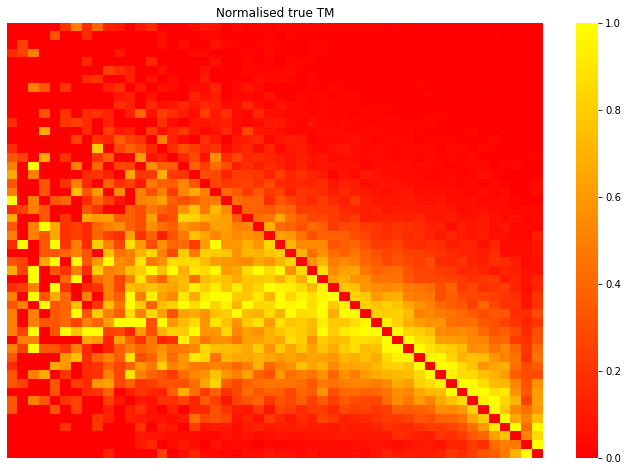

In [12]:
tmrca_data1 = get_coal_data(sim1, args) # get true coalescent 
coal_times_absolute1 = round_bin_coal_data(sim1.sequence_length,tmrca_data1, args) # partition coalescent data into bins  
coal_times1 = coal_times_absolute1/(2e+04) # scale by 2N
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals1 = round_coal_times(coal_times1,T_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm1 = tm_counts(coal_times_intervals1,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd1 = np.copy(tm1)
tm_nd1[range(0,len(tm1)),range(0,len(tm1))] = 0
tm_nd_norm1 = normalise(tm_nd1,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd1,'colmax'),title='Normalised true TM') # show heatmap


pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


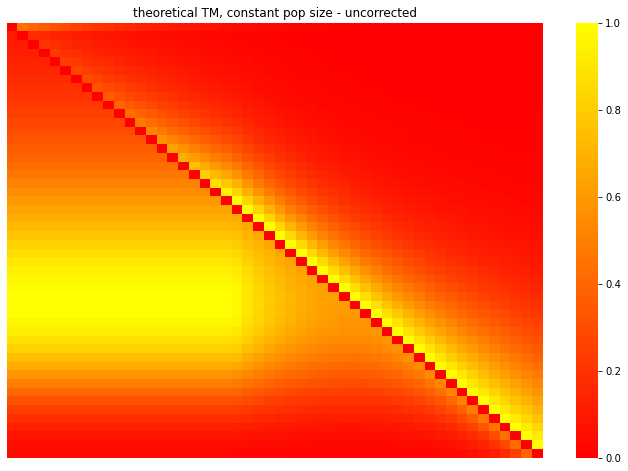

In [16]:
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2A, q_2_upperA, q_2_lowerA, q_1A, q_A = abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2A,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

I think there is a mistake in Schiffels' equation 26, see my notepad page 12 and 13. Below I implement what i believe to be the correction

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


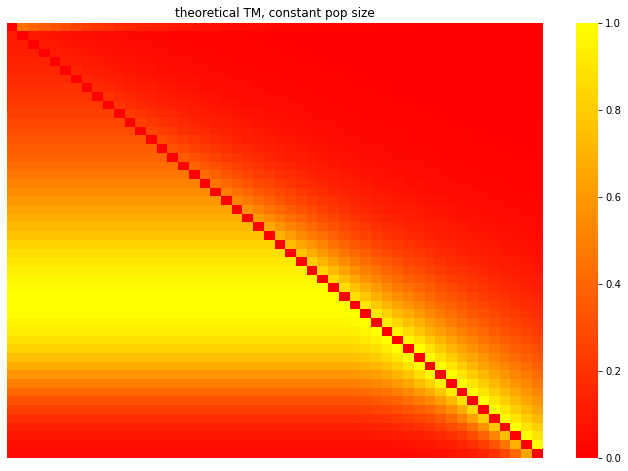

In [19]:
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Ac,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperAc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


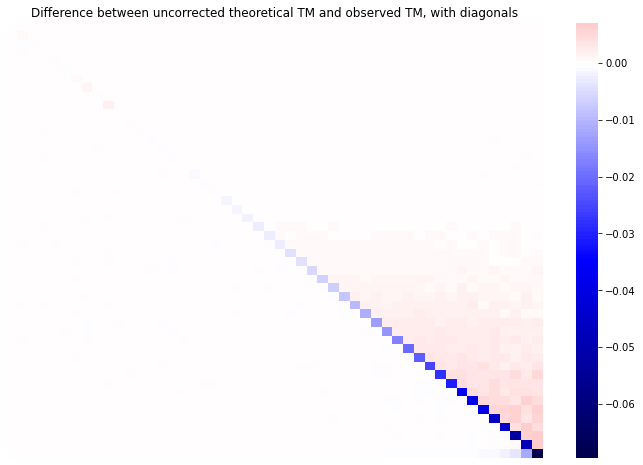

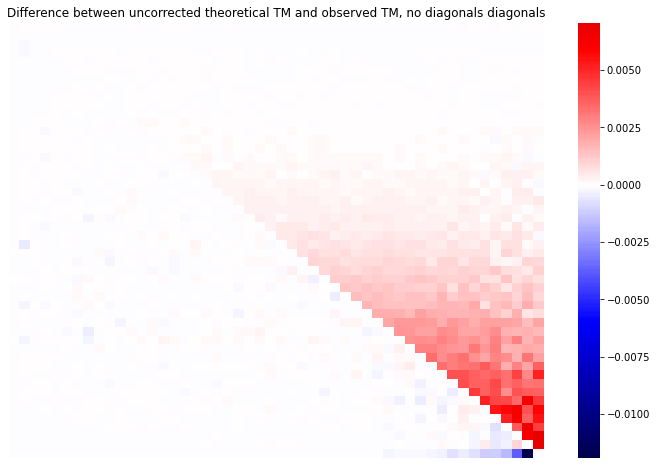

In [20]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_1 = normalise(tm1,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_tmA = q_A - tm_1
diff_q_tm_ndA = np.copy(diff_q_tmA)
diff_q_tm_ndA = remove_diagonals(diff_q_tm_ndA)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmA,title="Difference between uncorrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndA,title="Difference between uncorrected theoretical TM and observed TM, no diagonals diagonals")


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


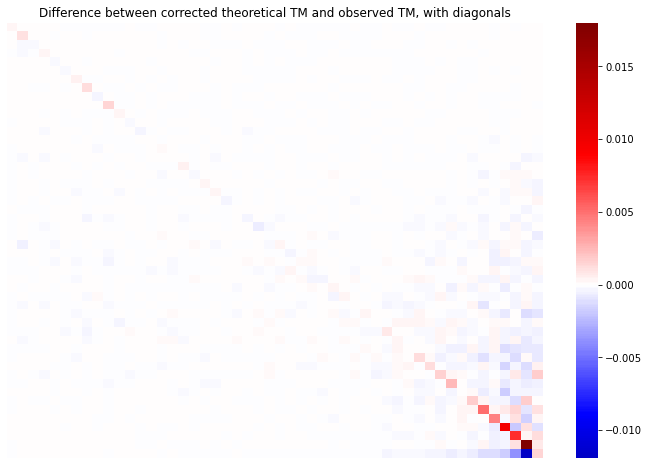

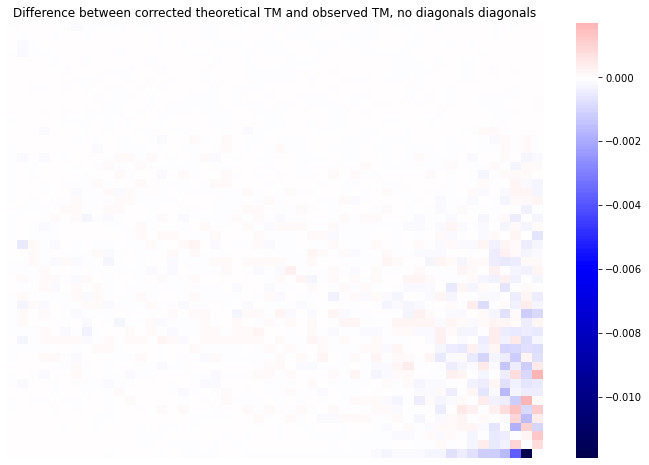

In [21]:

diff_q_tmAc = q_Ac - tm_1
diff_q_tm_ndAc = np.copy(diff_q_tmAc)
diff_q_tm_ndAc = remove_diagonals(diff_q_tm_ndAc)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmAc,title="Difference between corrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndAc,title="Difference between corrected theoretical TM and observed TM, no diagonals diagonals")


Now compare correction vs uncorrection

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


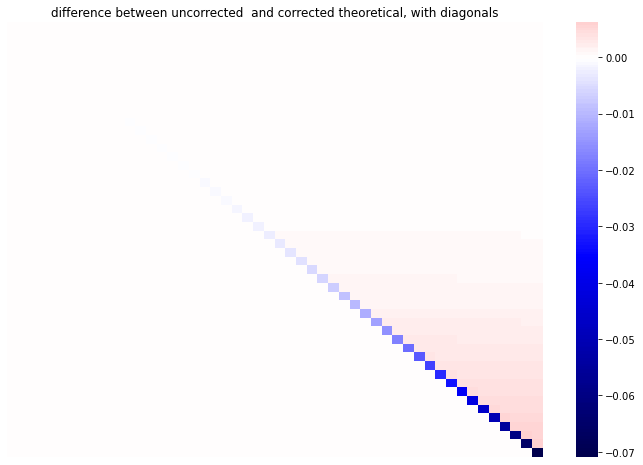

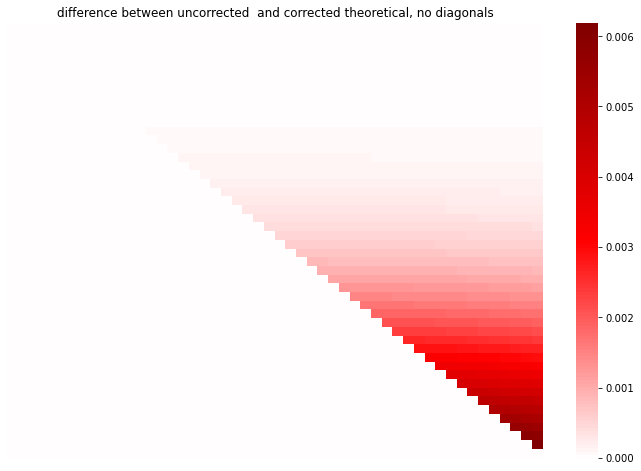

In [22]:

diff_q_A_q_Ac = q_A - q_Ac
diff_q_A_q_Ac_nd = np.copy(diff_q_A_q_Ac)
diff_q_A_q_Ac_nd = remove_diagonals(diff_q_A_q_Ac_nd)

heatmaps_div(diff_q_A_q_Ac,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_A_q_Ac_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

## Comparison for panmictic population of changing size

Compare observations against theoretical

In [32]:
sim2 = psc_pop(150e+06)


Model =  hudson(reference_size=1)
Epoch: 0 -- 15000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 15000.0
   - Population parameter change for -1: initial_size -> 20000 growth_rate -> 0 
Epoch: 15000.0 -- 26500.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 26500.0
   - Population parameter change for -1: initial_size -> 10000 growth_rate -> 0 
Epoch: 26500.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


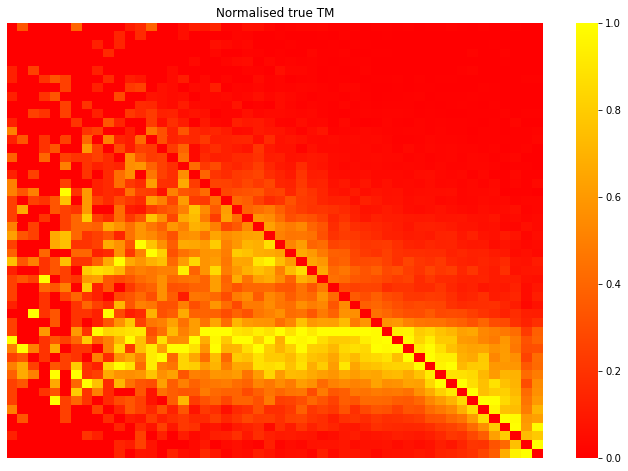

In [85]:
tmrca_data2 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute2 = round_bin_coal_data(sim2.sequence_length,tmrca_data2, args) # partition coalescent data into bins  
coal_times2 = coal_times_absolute2 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2 = round_coal_times(coal_times2,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2 = tm_counts(coal_times_intervals2,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2 = np.copy(tm2)
tm_nd2[range(0,len(tm2)),range(0,len(tm2))] = 0
tm_nd_norm2 = normalise(tm_nd2,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2,'colmax'),title='Normalised true TM') # show heatmap


#### Time changes that don't align with the predefined time intervals

We have above T_1 = 15000 and T_2 = 26500. We have from our predefind time intervals (scaling by coalescent time) that T_np*2*N_0[29:36] = [14339.2, 15943.7, 17727.7, 19711.3,21917.0, 24369.4, 27096.2]. I will investigate the effects of how we set these boundaries.

#### Scenario A: pop_size[29:35] = 2

In [95]:
[T_np*2*N_0][0][29:36]

array([14339.21266816, 15943.70415104, 17727.73079936, 19711.38176658,
       21916.99408938, 24369.40421542, 27096.22767576])

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 20000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


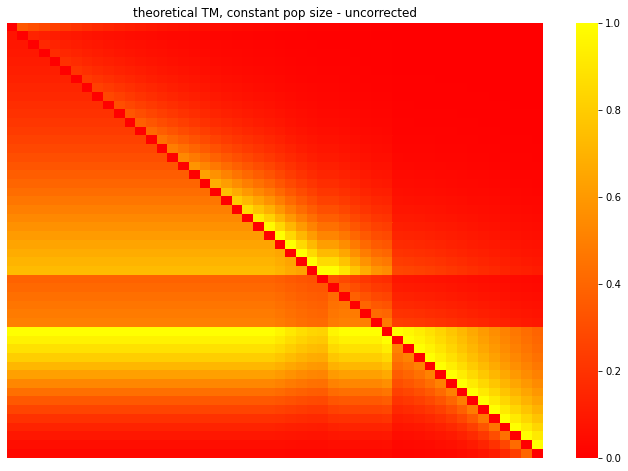

In [87]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[29:35] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2B, q_2_upperB, q_2_lowerB, q_1B, q_B = abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2B,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerB,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerB,'colmax')+normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

I think I spotted a mistake in equation 26 ( missing factor of (1/(2*lambda_alpha)), see my notedpad page 12 and 13), so I have tried to correct it

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 20000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


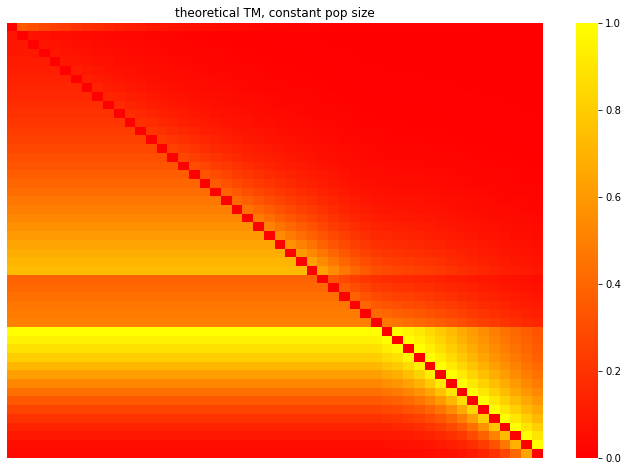

In [89]:
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

Comparison between (un)corrected TM and observation

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


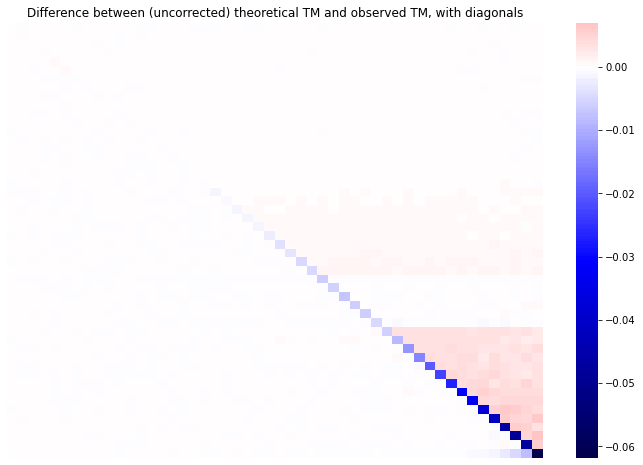

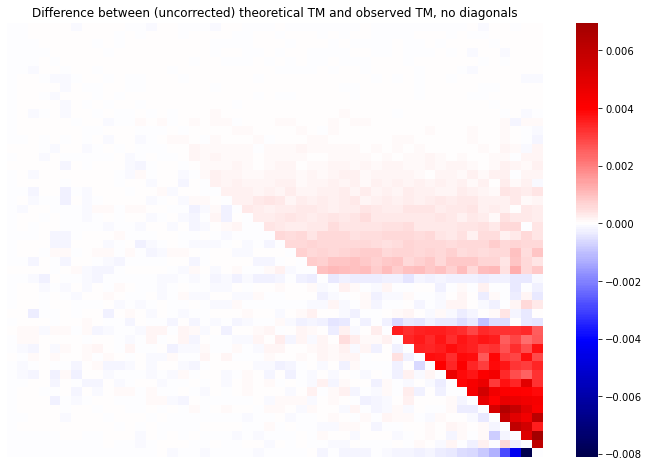

In [90]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_B_tm2 = q_B - tm_2
diff_q_B_tm_nd2 = np.copy(diff_q_B_tm2)
diff_q_B_tm_nd2 = remove_diagonals(diff_q_B_tm_nd2)

# heatmaps_seq(q_2B,title=" (uncorrected) theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_B_tm2,title="Difference between (uncorrected) theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_B_tm_nd2,title="Difference between (uncorrected) theoretical TM and observed TM, no diagonals")


Comparison between corrected TM and observation

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


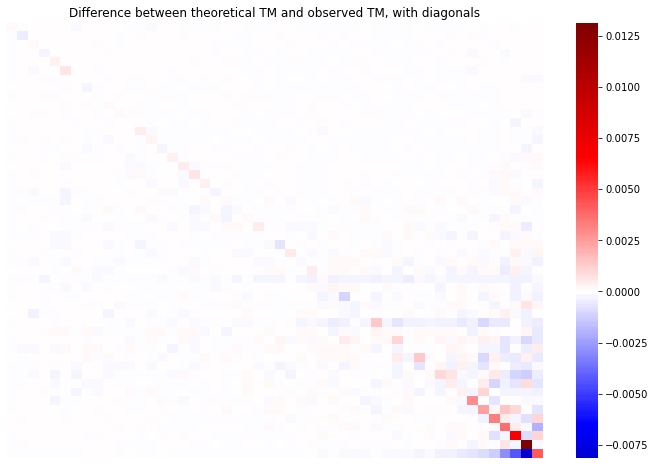

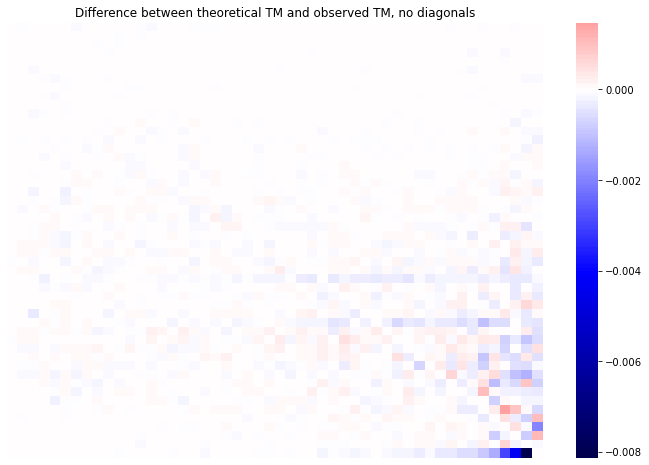

In [92]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


Difference between uncorrected and corrected theoretical  TM

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


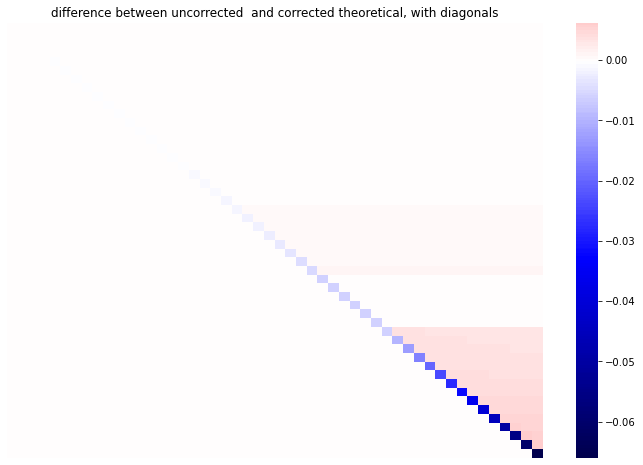

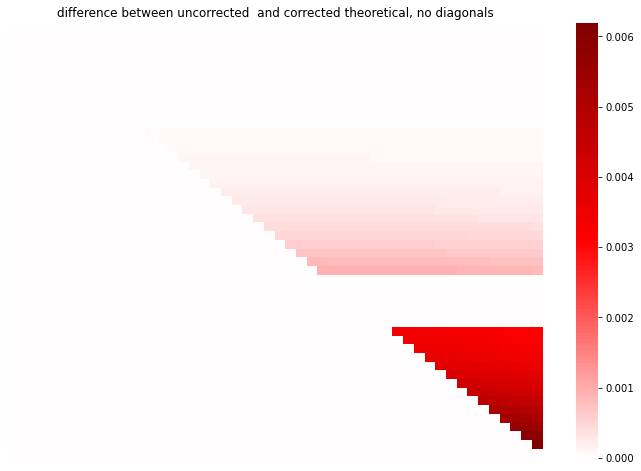

In [93]:

diff_q_B_q_Bc = q_B - q_Bc
diff_q_B_q_Bc_nd = np.copy(diff_q_B_q_Bc)
diff_q_B_q_Bc_nd = remove_diagonals(diff_q_B_q_Bc_nd)

heatmaps_div(diff_q_B_q_Bc,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_B_q_Bc_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

How do two theoretical matrices vary for different histories? I look because I want to gauge variability in randomness and accuracy, as when comparing theory to data

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


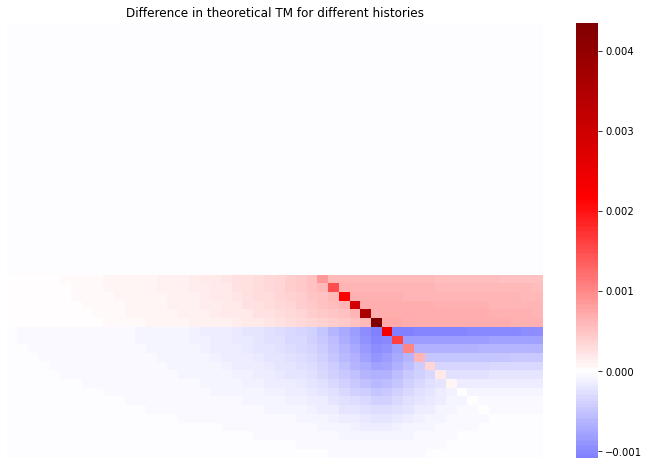

In [94]:
diff_qAc_qBc = q_Ac - q_Bc
heatmaps_div(diff_qAc_qBc,title="Difference in theoretical TM for different histories")

Ok cool, seems like a discernible difference

#### Scenario B: pop_size[29:36] = 2

I will now investiage a different scenario, where the pop size array is defined as above. 

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 20000.
 20000. 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


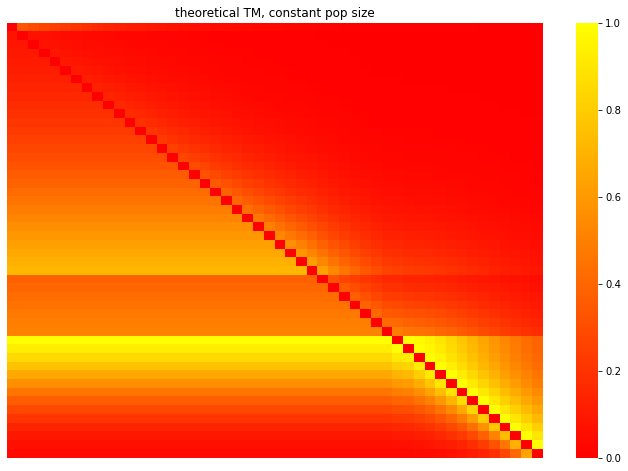

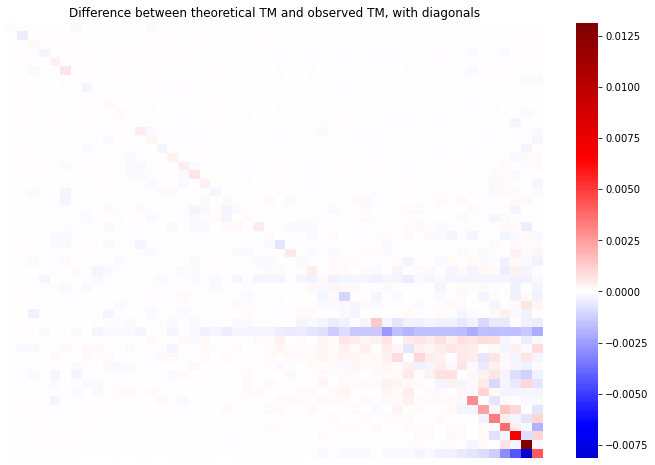

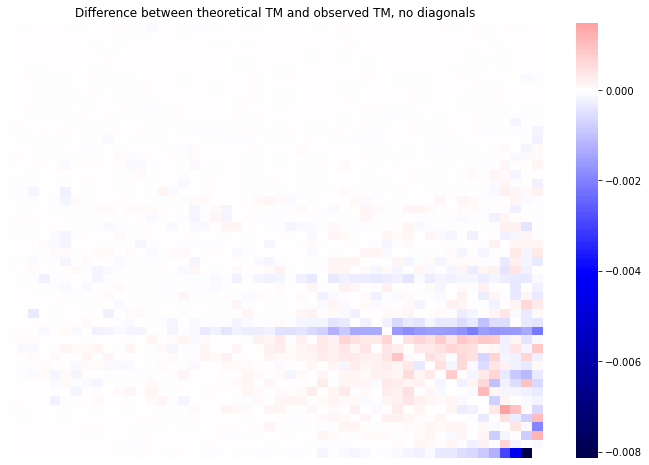

In [96]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[29:36] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04

q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


#### Scenario C: pop_size[30:35] = 2

I will now investiage a different scenario, where the pop size array is defined as above. 

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


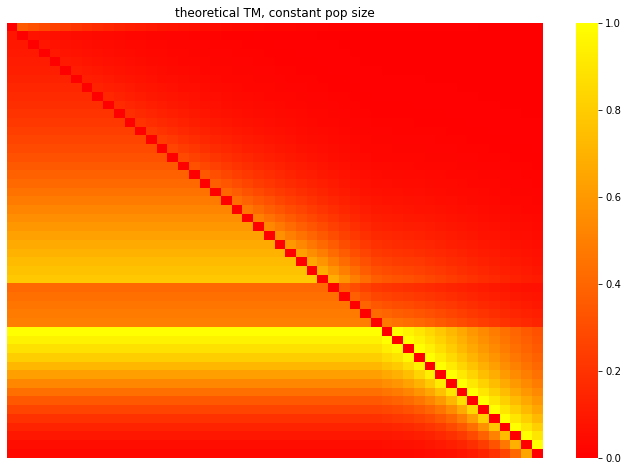

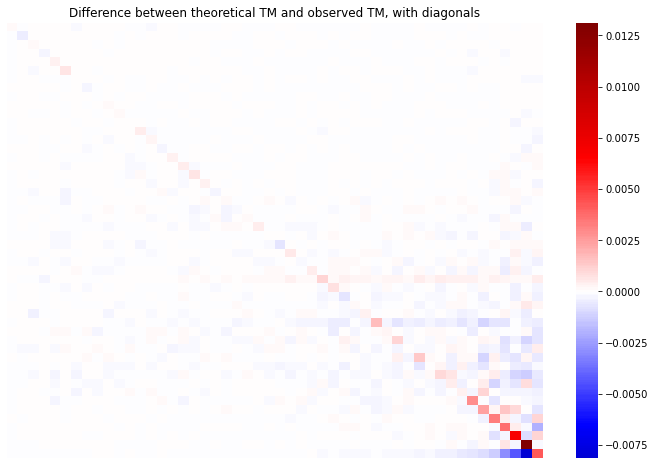

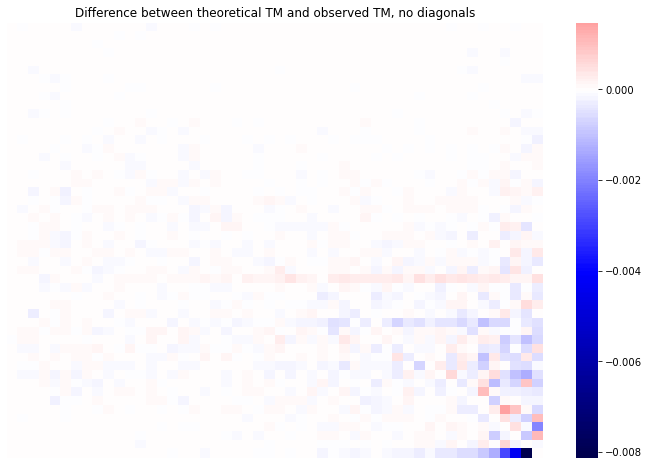

In [99]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[30:35] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04

q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


Analysis from scenario A, B and C show that how you define the time intervals is important. The conclusion that I draw is that, given some demographic change at time T_i,  you should take, always, the next lowest time interval when programming in that change. 

For example, suppose there is a population size change at T_1 = 40000, and suppose that you have time intervals T_int[i] = 37844 and T_int[i+1] = 41129. Then, you should, I think, always take the lower T_int[i]. 

#### Time changes that DO align with the predefined time intervals

This should mean there won't be any "streaks" , because the corresponding times of changing size match the time intervals

In [109]:
T_1 = T_np[30]*2*N_0
T_2 = T_np[35]*2*N_0
print('T_1 and T_2 are {}'.format([T_1,T_2]))
sim2a = sim2 = psc_pop(150e+06,T_1=T_1,T_2=T_2)


T_1 and T_2 are [15943.704151042171, 27096.22767576434]
Model =  hudson(reference_size=1)
Epoch: 0 -- 15943.704151042171 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 15943.704151042171
   - Population parameter change for -1: initial_size -> 20000 growth_rate -> 0 
Epoch: 15943.704151042171 -- 27096.22767576434 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 27096.22767576434
   - Population parameter change for -1: initial_size -> 10000 growth_rate -> 0 
Epoch: 27096.22767576434 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


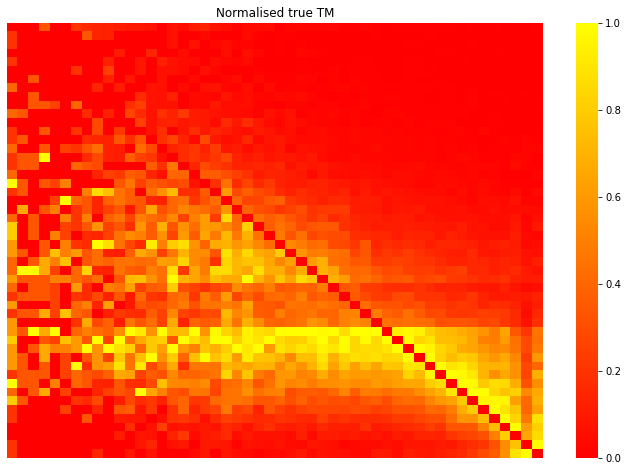

In [110]:
tmrca_data2 = get_coal_data(sim2a, args) # get true coalescent 
coal_times_absolute2 = round_bin_coal_data(sim2.sequence_length,tmrca_data2, args) # partition coalescent data into bins  
coal_times2 = coal_times_absolute2 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2 = round_coal_times(coal_times2,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2 = tm_counts(coal_times_intervals2,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2 = np.copy(tm2)
tm_nd2[range(0,len(tm2)),range(0,len(tm2))] = 0
tm_nd_norm2 = normalise(tm_nd2,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2,'colmax'),title='Normalised true TM') # show heatmap


pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


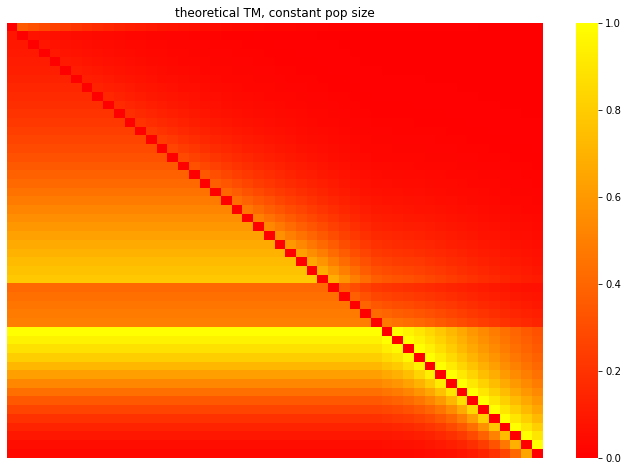

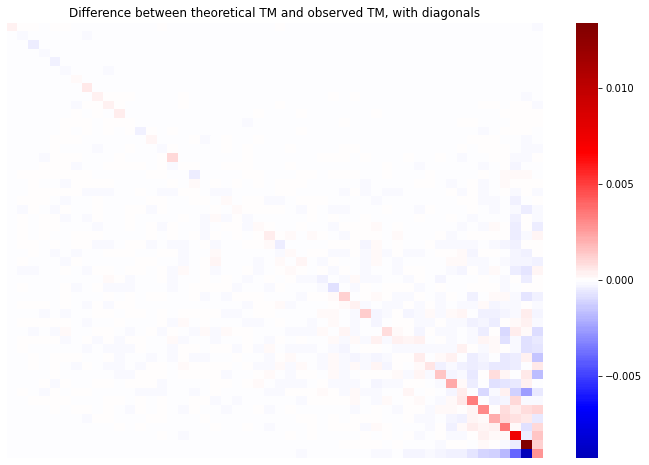

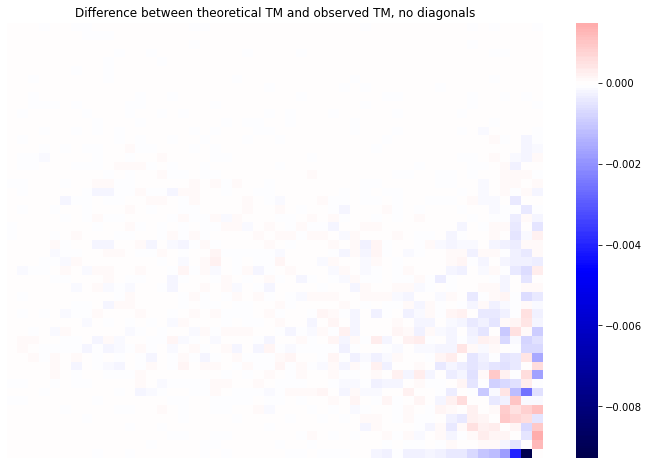

In [111]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[30:35] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04

q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


No streaks when the times of change align with time intervals. 

## Investigating the bad diagonals stuff

SOLVED: I think this is because the recombination rate was defined per bp per gen, which i specified as r=2e-08. The problem is that when I count observations of transitions in a genome sequence, I was counting by bins in some size (say bin_length=50). Therefore obviously the theory woulnd't be correct due to mismatch in rate of recombination. The solution is to multipy the recombination rate by the length of your bins, i.e. set r=2e-08*bin_length. Below are some examples demonstrating. 


##### The defaultl bin size used in the above analysis was: 50, I will fiddle with this now and see how things differ

Now I will change that and see how results differ

In [84]:
args.bin_length = 50

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


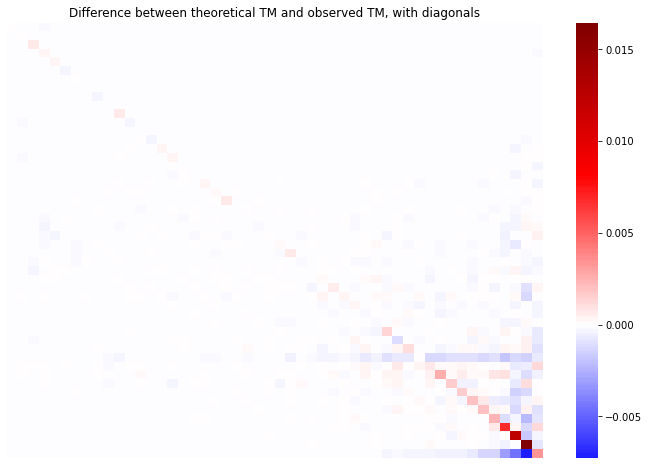

In [85]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [86]:
args.bin_length=20

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


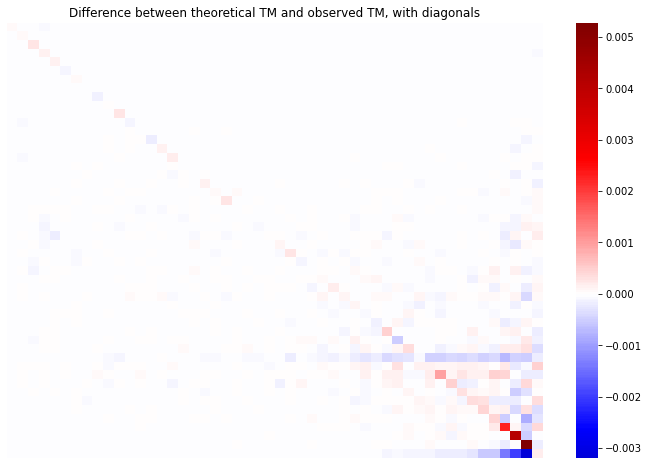

In [89]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [92]:
args.bin_length = 10

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


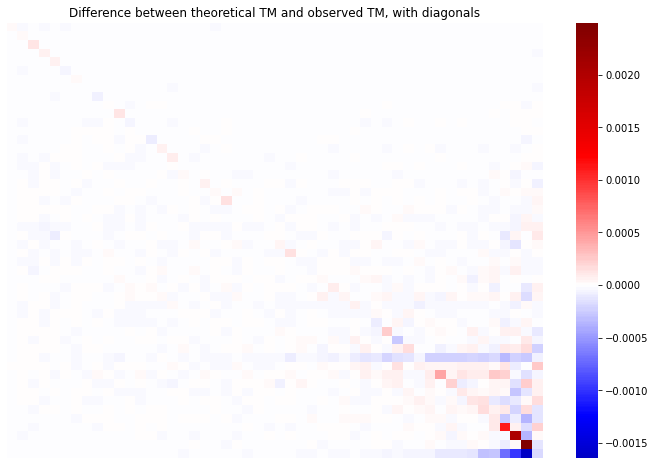

In [93]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [94]:
args.bin_length = 2

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


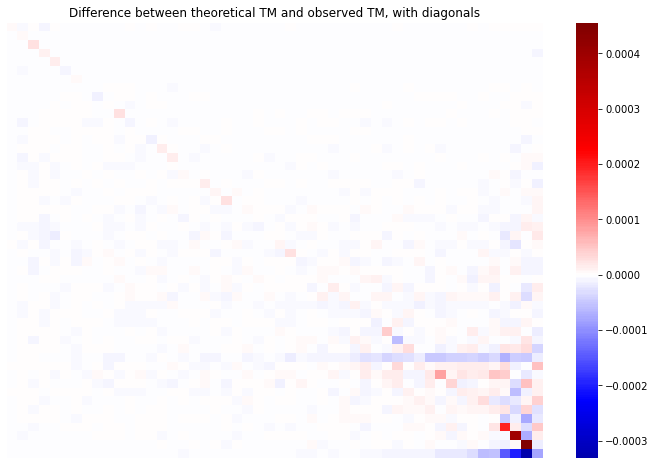

In [95]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


## TODO

Make a more effecient algorithm for getting this observed coalescent data

## Try out G function, as written in Distribution of coalesent times -Copy_210116


I will copy paste from the above notebook. I copy as of 2021/01/29 (ymd) - I hope that i don't change things in one script and not the other! 

In [113]:
def G(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def delta(i):
        delt = T[i+1] - T[i]
        return delt
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime  
  

I now need to rewrite my transition matrix theory with this function instead of L. In my notepad, page 15-17, I write what I expect the theoretical probabilities to be. They are cumbersome so I introduced new functions called H instead. I will also write that in the above block of code. 

Note that my G function is calibrated to run from t1=0 to t2 - i.e. it should be given G(0,t2)<br>.
Therefore, if you want a non t1!=0 start, you should do G(t1,t2)/G(0,t1) 

In [218]:
def structuredsplit_abinitio(T,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08):
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    
    def lambda_(int):
            lambd = lambda_array[int]
            return lambd
    
    def sigma(int):
        sig = (1-gamma_array[int])**2 + gamma_array[int]**2
        return sig
    
    def H_intervals(ind1): # for iterating through the intervals
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/lambda_)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H
        # TODO 210203 think we should have ((sigma)/lambda) above, not ((sigma)/gamma)

    def H_edge(ind1,t): # for the edge case where the upper boundary is t2, not an interval
        if t < T[ind1]:
            print('There has been an error! T[ind] is bigger than t2, whereas t2 should be bigger than T[ind]')
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = t - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/lambda_)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H
            # TODO 210203 think we should have ((sigma)/lambda) above, not ((sigma)/gamma)

#     def H_antidash(ind1): # let this be the integral of H, i.e. the antiderivate, i.e. the anti' of H - poor naming i know
    def J(ind1): # this used to be called H_antidash
        sig = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma_ = gamma_array[ind1]
        lambd = lambda_array[ind1]
        delt = T[ind1+1] - T[ind1]
        if sig==1:
            J = (1/(2*lambd))*(delt - (1/(2*lambd))*(1-np.exp(-2*delt*lambd)))
        else: 
            J = ((1-sig)**2)*( 0.5*(delt**2) ) + 2*(1-sig)*(sig/lambd)*(
                delt + (1/lambd)*(np.exp(-lambd*delt) - 1)
            ) + (((sig)**2)/(2*lambd))*(
            delt + (1/(2*lambd))*(np.exp(-2*lambd*delt) -1))
        return J
    
    def delta(int):
        delt = T[int+1] - T[int]
        return delt
    
    def delta_(int):
        delt = T[int+1] - T[int]
        return delt

    
    def expected_time(int):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix

    
    def upper_diag_sum(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G(T[j+1],T[alpha],gamma_array,lambda_array,T_np)**2) * H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
        
    def upper_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(alpha+1,N_T):
#                 if alpha ==1:
#                     pdb.set_trace()
                q_2[alpha,beta] = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha) * (
                    upper_diag_sum(alpha)*H_intervals(alpha) + J(alpha)               
                )
                pre = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha)
                A = upper_diag_sum(alpha)*H_intervals(alpha)
                B = J(alpha)
#                 print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    def lower_diag_sum(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G(T[j+1],expected_time(beta),gamma_array,lambda_array,T_np)**2)* H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
    def lower_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(0,alpha):

                # the integral of G over T[alpha] and T[alpha+1], see my notepad page 19
                G_integral_alpha = (1-sigma(alpha))*delta(alpha) + (sigma(alpha)/lambda_(alpha))*(1-np.exp(-delta(alpha)*lambda_(alpha)))
                
                
                q_2[alpha,beta] = G(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta))*(
                        lower_diag_sum(beta) + H_edge(beta,expected_time(beta))
                    ))

                pre = G(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta)))
                A = lower_diag_sum(beta) 
                B = H_edge(beta,expected_time(beta))
#                 print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nB={}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    # flagstr
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2_lower is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    
    return q_2, q_2_upper, q_2_lower, q_1, q_
    
    

In [115]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

# print(f'T_np is {T_np}\n\n')
# print(f'T_scaled_np is {T_scaled_np}')

In [116]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

# gamma_array[20:35] = 0.3

In [122]:
q_2s, q_2_uppers, q_2_lowers,q_1s, q_s = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)

expected_times conforms with T.


Upper_diag:
For alpha  0 and beta 1 we have q_2[alpha,beta] = 2.639475074593914e-05
with pre = 0.03996894030295883
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 2 we have q_2[alpha,beta] = 2.6392457045993246e-05
with pre = 0.03996546700794299
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 3 we have q_2[alpha,beta] = 2.6389907025621133e-05
with pre = 0.039961605573030974
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 4 we have q_2[alpha,beta] = 2.6387072082607332e-05
with pre = 0.039957312686571406
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 5 we have q_2[alpha,beta] = 2.6383920432893147e-05
with pre = 0.03995254021872374
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 6 we have q_2[alpha,beta] = 2.638041675892537e-05
with pre = 0.039947234688961136
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 7



Upper_diag:
For alpha  5 and beta 49 we have q_2[alpha,beta] = 1.2459162184597704e-05
with pre = 0.035372498334767105
A = 0.00033251690796017464
and B = 1.9710465596636806e-05


Upper_diag:
For alpha  6 and beta 7 we have q_2[alpha,beta] = 1.7280093754535437e-05
with pre = 0.039941336675572835
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 8 we have q_2[alpha,beta] = 1.7277257164782556e-05
with pre = 0.03993478016101107
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 9 we have q_2[alpha,beta] = 1.727410395405144e-05
with pre = 0.039927491806375406
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 10 we have q_2[alpha,beta] = 1.7270598878014737e-05
with pre = 0.0399193901476666
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 11 we have q_2[alpha,beta] = 1.7266702792062726e-05
with pre = 0.0399103847057438



Upper_diag:
For alpha  9 and beta 12 we have q_2[alpha,beta] = 3.18430189981397e-05
with pre = 0.03990037500117154
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 13 we have q_2[alpha,beta] = 3.183414011720066e-05
with pre = 0.03988924946439128
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 14 we have q_2[alpha,beta] = 3.182427187989524e-05
with pre = 0.039876884230771
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 15 we have q_2[alpha,beta] = 3.1813304559692375e-05
with pre = 0.03986314180927266
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 16 we have q_2[alpha,beta] = 3.180111638225608e-05
with pre = 0.039847869612552954
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 17 we have q_2[alpha,beta] = 3.1787572231353264e-05
with pre = 0.03983089833542227
A = 0.00075211710745602
and



Upper_diag:
For alpha  11 and beta 23 we have q_2[alpha,beta] = 4.741032467634033e-05
with pre = 0.03968131226338838
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 24 we have q_2[alpha,beta] = 4.736798912934206e-05
with pre = 0.039645878419141405
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 25 we have q_2[alpha,beta] = 4.732097984367156e-05
with pre = 0.03960653276697166
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 26 we have q_2[alpha,beta] = 4.726878870433398e-05
with pre = 0.03956285002673365
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 27 we have q_2[alpha,beta] = 4.721085420237734e-05
with pre = 0.03951436022881179
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 28 we have q_2[alpha,beta] = 4.71465562603733e-05
with pre = 0.03946054438317113
A = 0.



Upper_diag:
For alpha  13 and beta 17 we have q_2[alpha,beta] = 7.09121543855455e-05
with pre = 0.03983089833542227
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 18 we have q_2[alpha,beta] = 7.087858061847708e-05
with pre = 0.03981204016767336
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 19 we have q_2[alpha,beta] = 7.084127675059057e-05
with pre = 0.03979108682642769
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 20 we have q_2[alpha,beta] = 7.079983166913175e-05
with pre = 0.039767807392311026
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 21 we have q_2[alpha,beta] = 7.075378973015462e-05
with pre = 0.03974194593306677
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 22 we have q_2[alpha,beta] = 7.070264611912298e-05
with pre = 0.039713218897635974




Upper_diag:
For alpha  14 and beta 32 we have q_2[alpha,beta] = 8.497130179554419e-05
with pre = 0.03917965454160628
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 33 we have q_2[alpha,beta] = 8.477548082758803e-05
with pre = 0.03908936290531965
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 34 we have q_2[alpha,beta] = 8.455850684088019e-05
with pre = 0.03898931776461811
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 35 we have q_2[alpha,beta] = 8.431818808774539e-05
with pre = 0.03887850852045298
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 36 we have q_2[alpha,beta] = 8.405212747761634e-05
with pre = 0.03875582989164878
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 37 we have q_2[alpha,beta] = 8.37577084834783e-05
with pre = 0.03862007541646643
A = 0.0020366470942865



Upper_diag:
For alpha  16 and beta 38 we have q_2[alpha,beta] = 0.00012321339872556713
with pre = 0.03846993110371682
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 39 we have q_2[alpha,beta] = 0.00012268184844888168
with pre = 0.03830396942476179
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 40 we have q_2[alpha,beta] = 0.00012209468435264096
with pre = 0.03812064388904414
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 41 we have q_2[alpha,beta] = 0.00012144655770864081
with pre = 0.03791828450606256
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 42 we have q_2[alpha,beta] = 0.00012073171373521314
with pre = 0.03769509450649993
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 43 we have q_2[alpha,beta] = 0.00011994398657660485
with pre = 0.037449148774675076



Upper_diag:
For alpha  18 and beta 49 we have q_2[alpha,beta] = 0.00016605954791841184
with pre = 0.035372498334767105
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  19 and beta 20 we have q_2[alpha,beta] = 0.00022529018638370232
with pre = 0.039767807392311026
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 21 we have q_2[alpha,beta] = 0.00022514367760297384
with pre = 0.03974194593306677
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 22 we have q_2[alpha,beta] = 0.00022498093493268756
with pre = 0.039713218897635974
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 23 we have q_2[alpha,beta] = 0.00022480017939075875
with pre = 0.03968131226338838
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 24 we have q_2[alpha,beta] = 0.00022459944171125985
with pre = 0.039645878419



Upper_diag:
For alpha  20 and beta 46 we have q_2[alpha,beta] = 0.00024928390716343995
with pre = 0.03655363617434563
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 47 we have q_2[alpha,beta] = 0.00024683771144644323
with pre = 0.03619493934041116
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 48 we have q_2[alpha,beta] = 0.0002441585202037655
with pre = 0.03580207730996278
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 49 we have q_2[alpha,beta] = 0.00024122893134258402
with pre = 0.035372498334767105
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  21 and beta 22 we have q_2[alpha,beta] = 0.00032516286137777633
with pre = 0.039713218897635974
A = 0.007611437029245156
and B = 0.000576336976581715


Upper_diag:
For alpha  21 and beta 23 we have q_2[alpha,beta] = 0.00032490161706727043
with pre = 0.03968131226338838
A = 0.007



Upper_diag:
For alpha  22 and beta 42 we have q_2[alpha,beta] = 0.0003694933455624048
with pre = 0.03769509450649993
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 43 we have q_2[alpha,beta] = 0.00036708254616082514
with pre = 0.037449148774675076
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 44 we have q_2[alpha,beta] = 0.00036442856977901946
with pre = 0.03717839453313952
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 45 we have q_2[alpha,beta] = 0.0003615100784358612
with pre = 0.0368806549166674
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 46 we have q_2[alpha,beta] = 0.00035830458841802225
with pre = 0.03655363617434563
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 47 we have q_2[alpha,beta] = 0.0003547885846793863
with pre = 0.03619493934041116
A = 0.0090914



Upper_diag:
For alpha  25 and beta 35 we have q_2[alpha,beta] = 0.0006412506526650764
with pre = 0.03887850852045298
A = 0.015163222315277752
and B = 0.001330482743591238


Upper_diag:
For alpha  25 and beta 36 we have q_2[alpha,beta] = 0.0006392272275445535
with pre = 0.03875582989164878
A = 0.015163222315277752
and B = 0.001330482743591238


Upper_diag:
For alpha  25 and beta 37 we have q_2[alpha,beta] = 0.0006369881332704742
with pre = 0.03862007541646643
A = 0.015163222315277752
and B = 0.001330482743591238


Upper_diag:
For alpha  25 and beta 38 we have q_2[alpha,beta] = 0.0006345116972597156
with pre = 0.03846993110371682
A = 0.015163222315277752
and B = 0.001330482743591238


Upper_diag:
For alpha  25 and beta 39 we have q_2[alpha,beta] = 0.0006317743742759567
with pre = 0.03830396942476179
A = 0.015163222315277752
and B = 0.001330482743591238


Upper_diag:
For alpha  25 and beta 40 we have q_2[alpha,beta] = 0.0006287506569600706
with pre = 0.03812064388904414
A = 0.0151632223



Upper_diag:
For alpha  27 and beta 46 we have q_2[alpha,beta] = 0.0008372554689434343
with pre = 0.03655363617434563
A = 0.020887672991372813
and B = 0.00201717469464327


Upper_diag:
For alpha  27 and beta 47 we have q_2[alpha,beta] = 0.000829039572596709
with pre = 0.03619493934041116
A = 0.020887672991372813
and B = 0.00201717469464327


Upper_diag:
For alpha  27 and beta 48 we have q_2[alpha,beta] = 0.0008200411276276699
with pre = 0.03580207730996278
A = 0.020887672991372813
and B = 0.00201717469464327


Upper_diag:
For alpha  27 and beta 49 we have q_2[alpha,beta] = 0.0008102016866316981
with pre = 0.035372498334767105
A = 0.020887672991372813
and B = 0.00201717469464327


Upper_diag:
For alpha  28 and beta 29 we have q_2[alpha,beta] = 0.001056917738209761
with pre = 0.0394008298164379
A = 0.02434267320386998
and B = 0.0024820851358342833


Upper_diag:
For alpha  28 and beta 30 we have q_2[alpha,beta] = 0.0010551407416820814
with pre = 0.03933458517388881
A = 0.0243426732038699



Upper_diag:
For alpha  30 and beta 44 we have q_2[alpha,beta] = 0.0013498326625203758
with pre = 0.03717839453313952
A = 0.03255487380868473
and B = 0.0037520372204395136


Upper_diag:
For alpha  30 and beta 45 we have q_2[alpha,beta] = 0.001339022656755277
with pre = 0.0368806549166674
A = 0.03255487380868473
and B = 0.0037520372204395136


Upper_diag:
For alpha  30 and beta 46 we have q_2[alpha,beta] = 0.0013271496163729441
with pre = 0.03655363617434563
A = 0.03255487380868473
and B = 0.0037520372204395136


Upper_diag:
For alpha  30 and beta 47 we have q_2[alpha,beta] = 0.001314126442336857
with pre = 0.03619493934041116
A = 0.03255487380868473
and B = 0.0037520372204395136


Upper_diag:
For alpha  30 and beta 48 we have q_2[alpha,beta] = 0.0012998628355506464
with pre = 0.03580207730996278
A = 0.03255487380868473
and B = 0.0037520372204395136


Upper_diag:
For alpha  30 and beta 49 we have q_2[alpha,beta] = 0.0012842661499182348
with pre = 0.035372498334767105
A = 0.032554873808



Upper_diag:
For alpha  33 and beta 48 we have q_2[alpha,beta] = 0.0019775477006992396
with pre = 0.03580207730996278
A = 0.04829632454369083
and B = 0.006939232979362164


Upper_diag:
For alpha  33 and beta 49 we have q_2[alpha,beta] = 0.0019538196665041248
with pre = 0.035372498334767105
A = 0.04829632454369083
and B = 0.006939232979362164


Upper_diag:
For alpha  34 and beta 35 we have q_2[alpha,beta] = 0.002447560755372914
with pre = 0.03887850852045298
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 36 we have q_2[alpha,beta] = 0.002439837635098736
with pre = 0.03875582989164878
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 37 we have q_2[alpha,beta] = 0.0024312913369389758
with pre = 0.03862007541646643
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 38 we have q_2[alpha,beta] = 0.00242183913978653
with pre = 0.03846993110371682
A = 0.05444984645450609




Upper_diag:
For alpha  38 and beta 43 we have q_2[alpha,beta] = 0.00382510413024961
with pre = 0.037449148774675076
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 44 we have q_2[alpha,beta] = 0.00379744894444521
with pre = 0.03717839453313952
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 45 we have q_2[alpha,beta] = 0.003767037437802992
with pre = 0.0368806549166674
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 46 we have q_2[alpha,beta] = 0.003733635323660148
with pre = 0.03655363617434563
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 47 we have q_2[alpha,beta] = 0.0036969975685740286
with pre = 0.03619493934041116
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 48 we have q_2[alpha,beta] = 0.003656870136457265
with pre = 0.03580207730996278
A = 0.08315432636584245
and 



Upper_diag:
For alpha  44 and beta 47 we have q_2[alpha,beta] = 0.0071223007592074805
with pre = 0.03619493934041116
A = 0.13614465701150502
and B = 0.06063149150535485


Upper_diag:
For alpha  44 and beta 48 we have q_2[alpha,beta] = 0.007044994881957335
with pre = 0.03580207730996278
A = 0.13614465701150502
and B = 0.06063149150535485


Upper_diag:
For alpha  44 and beta 49 we have q_2[alpha,beta] = 0.006960463985734511
with pre = 0.035372498334767105
A = 0.13614465701150502
and B = 0.06063149150535485


Upper_diag:
For alpha  45 and beta 46 we have q_2[alpha,beta] = 0.008000465149511355
with pre = 0.03655363617434563
A = 0.1458002084803676
and B = 0.07306899269437916


Upper_diag:
For alpha  45 and beta 47 we have q_2[alpha,beta] = 0.007921957460004205
with pre = 0.03619493934041116
A = 0.1458002084803676
and B = 0.07306899269437916


Upper_diag:
For alpha  45 and beta 48 we have q_2[alpha,beta] = 0.00783597206122808
with pre = 0.03580207730996278
A = 0.1458002084803676
and B = 0.



Lower_diag:
For alpha  14 and beta 13 we have q_2[alpha,beta] = 7.774573599783915e-05
with pre = 0.0006418901081781873
A = 0.11384205511886075
B=0.007277954376996909


Lower_diag:
For alpha  15 and beta 0 we have q_2[alpha,beta] = 1.1191044928717524e-05
with pre = 0.0006234207962634048
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  15 and beta 1 we have q_2[alpha,beta] = 2.3774129893329094e-05
with pre = 0.0006361116326059859
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  15 and beta 2 we have q_2[alpha,beta] = 2.643351088336593e-05
with pre = 0.0006388269073864155
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  15 and beta 3 we have q_2[alpha,beta] = 2.9390484533527597e-05
with pre = 0.0006418595949826694
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:
For alpha  15 and beta 4 we have q_2[alpha,beta] = 3.267843623357007e-05
with pre = 0.0006452485027387048
A = 0.047826070605396974
B=0.0028186594402662135


Lower_di



Lower_diag:
For alpha  19 and beta 6 we have q_2[alpha,beta] = 5.6401174005835746e-05
with pre = 0.0009120147841111763
A = 0.05836074808893523
B=0.0034816419560931844


Lower_diag:
For alpha  19 and beta 7 we have q_2[alpha,beta] = 6.27132703465425e-05
with pre = 0.000918640424030381
A = 0.06439827708486077
B=0.0038692068033384097


Lower_diag:
For alpha  19 and beta 8 we have q_2[alpha,beta] = 6.97334008309024e-05
with pre = 0.0009260638712712115
A = 0.07100119019742739
B=0.004299664305382533


Lower_diag:
For alpha  19 and beta 9 we have q_2[alpha,beta] = 7.754175938850002e-05
with pre = 0.0009343882955073347
A = 0.07820895259903739
B=0.004777702693340824


Lower_diag:
For alpha  19 and beta 10 we have q_2[alpha,beta] = 8.622795071427598e-05
with pre = 0.0009437319129480311
A = 0.08606060730852329
B=0.005308508783902766


Lower_diag:
For alpha  19 and beta 11 we have q_2[alpha,beta] = 9.589222489170283e-05
with pre = 0.0009542305828405882
A = 0.09459385233060295
B=0.005897817729108



Lower_diag:
For alpha  21 and beta 19 we have q_2[alpha,beta] = 0.0002619490065810232
with pre = 0.0012843232307958904
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  21 and beta 20 we have q_2[alpha,beta] = 0.0002918656105693499
with pre = 0.0013217563334676171
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  22 and beta 0 we have q_2[alpha,beta] = 1.9468418392648398e-05
with pre = 0.001084529369119856
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  22 and beta 1 we have q_2[alpha,beta] = 4.135848891972428e-05
with pre = 0.0011066068885332563
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  22 and beta 2 we have q_2[alpha,beta] = 4.5984861354941175e-05
with pre = 0.0011113304961867972
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  22 and beta 3 we have q_2[alpha,beta] = 5.112893865639663e-05
with pre = 0.0011166062886935862
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:



Lower_diag:
For alpha  25 and beta 21 we have q_2[alpha,beta] = 0.00041908561670752313
with pre = 0.0017576522800476242
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  25 and beta 22 we have q_2[alpha,beta] = 0.000467539763581917
with pre = 0.0018211962310153297
A = 0.23810701101481418
B=0.018614233856893203


Lower_diag:
For alpha  25 and beta 23 we have q_2[alpha,beta] = 0.0005220525581648139
with pre = 0.0018945463435029594
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  25 and beta 24 we have q_2[alpha,beta] = 0.0005835552449645196
with pre = 0.0019795713084470117
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  26 and beta 0 we have q_2[alpha,beta] = 2.4599387984191032e-05
with pre = 0.0013703608682102094
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  26 and beta 1 we have q_2[alpha,beta] = 5.225866297183893e-05
with pre = 0.00139825699489217
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
Fo



Lower_diag:
For alpha  28 and beta 17 we have q_2[alpha,beta] = 0.00031073144244559727
with pre = 0.0017985094483225893
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  28 and beta 18 we have q_2[alpha,beta] = 0.0003459390967080774
with pre = 0.0018407966664648599
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  28 and beta 19 we have q_2[alpha,beta] = 0.0003852744550763379
with pre = 0.0018889819027953331
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  28 and beta 20 we have q_2[alpha,beta] = 0.00042927577979894955
with pre = 0.0019440384896551317
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  28 and beta 21 we have q_2[alpha,beta] = 0.00047857178945443635
with pre = 0.0020071383110437384
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  28 and beta 22 we have q_2[alpha,beta] = 0.0005339036520899178
with pre = 0.0020797018663442843
A = 0.23810701101481418
B=0.018614233



Lower_diag:
For alpha  30 and beta 23 we have q_2[alpha,beta] = 0.0006275637382437034
with pre = 0.0022774499751216644
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  30 and beta 24 we have q_2[alpha,beta] = 0.0007014966314675879
with pre = 0.0023796591952659004
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  30 and beta 25 we have q_2[alpha,beta] = 0.0007851973209027531
with pre = 0.002498689697354332
A = 0.28889483391491694
B=0.025348796150127695


Lower_diag:
For alpha  30 and beta 26 we have q_2[alpha,beta] = 0.0008803525341640233
with pre = 0.002638029471443616
A = 0.3056388777919047
B=0.02807708091657235


Lower_diag:
For alpha  30 and beta 27 we have q_2[alpha,beta] = 0.0009890749236910095
with pre = 0.002802085418212899
A = 0.32189223697888775
B=0.031085911817809897


Lower_diag:
For alpha  30 and beta 28 we have q_2[alpha,beta] = 0.0011140481553928816
with pre = 0.0029964818829417957
A = 0.3373842480697169
B=0.034401131890319736




Lower_diag:
For alpha  32 and beta 20 we have q_2[alpha,beta] = 0.0004579817712497087
with pre = 0.0020740377928772312
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  32 and beta 21 we have q_2[alpha,beta] = 0.0005105742418245366
with pre = 0.002141357146367496
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  32 and beta 22 we have q_2[alpha,beta] = 0.0005696061873682889
with pre = 0.002218773080712277
A = 0.23810701101481418
B=0.018614233856893203


Lower_diag:
For alpha  32 and beta 23 we have q_2[alpha,beta] = 0.000636019415726168
with pre = 0.002308135913933186
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  32 and beta 24 we have q_2[alpha,beta] = 0.0007109484670489831
with pre = 0.002411722282163913
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  32 and beta 25 we have q_2[alpha,beta] = 0.0007957769240586491
with pre = 0.0025323565791737224
A = 0.28889483391491694
B=0.025348796150127695



Lower_diag:
For alpha  34 and beta 28 we have q_2[alpha,beta] = 0.001091827328532642
with pre = 0.0029367139951818515
A = 0.3373842480697169
B=0.034401131890319736


Lower_diag:
For alpha  34 and beta 29 we have q_2[alpha,beta] = 0.0012336238875865894
with pre = 0.0031640796866722843
A = 0.3518336791483463
B=0.03805027124103605


Lower_diag:
For alpha  34 and beta 30 we have q_2[alpha,beta] = 0.0013991681120703353
with pre = 0.003437573215199877
A = 0.36495956559846887
B=0.04206248876350083


Lower_diag:
For alpha  34 and beta 31 we have q_2[alpha,beta] = 0.0015943399665957828
with pre = 0.003769458986656137
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  34 and beta 32 we have q_2[alpha,beta] = 0.001827057604938302
with pre = 0.0041761610855509225
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  34 and beta 33 we have q_2[alpha,beta] = 0.002108146121150227
with pre = 0.004679991913741018
A = 0.39386849950967007
B=0.05659085170426187


Low



Lower_diag:
For alpha  36 and beta 29 we have q_2[alpha,beta] = 0.0011257502117014912
with pre = 0.0028873981875303907
A = 0.3518336791483463
B=0.03805027124103605


Lower_diag:
For alpha  36 and beta 30 we have q_2[alpha,beta] = 0.0012768184972898368
with pre = 0.0031369761997082015
A = 0.36495956559846887
B=0.04206248876350083


Lower_diag:
For alpha  36 and beta 31 we have q_2[alpha,beta] = 0.0014549236383795058
with pre = 0.0034398403718737826
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  36 and beta 32 we have q_2[alpha,beta] = 0.0016672913894152713
with pre = 0.0038109785919887926
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  36 and beta 33 we have q_2[alpha,beta] = 0.001923800249057649
with pre = 0.0042707521641481005
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  36 and beta 34 we have q_2[alpha,beta] = 0.0022381672268714076
with pre = 0.004847253218367457
A = 0.3993650444202411
B=0.062374238848565855





Lower_diag:
For alpha  38 and beta 25 we have q_2[alpha,beta] = 0.0005965366924590141
with pre = 0.001898325488206517
A = 0.28889483391491694
B=0.025348796150127695


Lower_diag:
For alpha  38 and beta 26 we have q_2[alpha,beta] = 0.0006688288089474509
with pre = 0.0020041858697315614
A = 0.3056388777919047
B=0.02807708091657235


Lower_diag:
For alpha  38 and beta 27 we have q_2[alpha,beta] = 0.0007514282943482694
with pre = 0.002128823829208375
A = 0.32189223697888775
B=0.031085911817809897


Lower_diag:
For alpha  38 and beta 28 we have q_2[alpha,beta] = 0.0008463740058283294
with pre = 0.0022765123413925163
A = 0.3373842480697169
B=0.034401131890319736


Lower_diag:
For alpha  38 and beta 29 we have q_2[alpha,beta] = 0.0009562933296654181
with pre = 0.002452764030707997
A = 0.3518336791483463
B=0.03805027124103605


Lower_diag:
For alpha  38 and beta 30 we have q_2[alpha,beta] = 0.0010846216145109307
with pre = 0.00266477357402939
A = 0.36495956559846887
B=0.04206248876350083


L



Lower_diag:
For alpha  40 and beta 2 we have q_2[alpha,beta] = 3.922107350785745e-05
with pre = 0.0009478679243159768
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  40 and beta 3 we have q_2[alpha,beta] = 4.360852250793596e-05
with pre = 0.0009523677148910491
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:
For alpha  40 and beta 4 we have q_2[alpha,beta] = 4.848706459364886e-05
with pre = 0.0009573960518682024
A = 0.047826070605396974
B=0.0028186594402662135


Lower_diag:
For alpha  40 and beta 5 we have q_2[alpha,beta] = 5.391185403260623e-05
with pre = 0.0009630181580371581
A = 0.05284944373853618
B=0.00313273435714001


Lower_diag:
For alpha  40 and beta 6 we have q_2[alpha,beta] = 5.9944326737403254e-05
with pre = 0.0009693080538083481
A = 0.05836074808893523
B=0.0034816419560931844


Lower_diag:
For alpha  40 and beta 7 we have q_2[alpha,beta] = 6.665295243739566e-05
with pre = 0.0009763499200666657
A = 0.06439827708486077
B=0.0038692068033



Lower_diag:
For alpha  41 and beta 30 we have q_2[alpha,beta] = 0.0007148077849897998
with pre = 0.0017561893202821695
A = 0.36495956559846887
B=0.04206248876350083


Lower_diag:
For alpha  41 and beta 31 we have q_2[alpha,beta] = 0.0008145172908184128
with pre = 0.0019257433081966357
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  41 and beta 32 we have q_2[alpha,beta] = 0.0009334082076114848
with pre = 0.0021335195031754644
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  41 and beta 33 we have q_2[alpha,beta] = 0.0010770108654523714
with pre = 0.0023909168775161646
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  41 and beta 34 we have q_2[alpha,beta] = 0.0012530045274818308
with pre = 0.0027136623910605836
A = 0.3993650444202411
B=0.062374238848565855


Lower_diag:
For alpha  41 and beta 35 we have q_2[alpha,beta] = 0.001472227377821683
with pre = 0.0031238193570235716
A = 0.40260629724188624
B=0.06868452004290271



Lower_diag:
For alpha  42 and beta 39 we have q_2[alpha,beta] = 0.0026539993107853885
with pre = 0.0053764031393973505
A = 0.3937876356052148
B=0.09985081411172358


Lower_diag:
For alpha  42 and beta 40 we have q_2[alpha,beta] = 0.003386671505463667
with pre = 0.006826700898519022
A = 0.38682339369224145
B=0.10926857749670699


Lower_diag:
For alpha  42 and beta 41 we have q_2[alpha,beta] = 0.004430720381782784
with pre = 0.008901926533580242
A = 0.3783453351437695
B=0.11938067563255234


Lower_diag:
For alpha  43 and beta 0 we have q_2[alpha,beta] = 9.20237841828174e-06
with pre = 0.000512637927698841
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  43 and beta 1 we have q_2[alpha,beta] = 1.9549429140650416e-05
with pre = 0.0005230735822076729
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  43 and beta 2 we have q_2[alpha,beta] = 2.173623389253771e-05
with pre = 0.000525306348334365
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha 



Lower_diag:
For alpha  44 and beta 30 we have q_2[alpha,beta] = 0.0003579650299153868
with pre = 0.0008794733014566433
A = 0.36495956559846887
B=0.04206248876350083


Lower_diag:
For alpha  44 and beta 31 we have q_2[alpha,beta] = 0.00040789805664829686
with pre = 0.0009643833984513776
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  44 and beta 32 we have q_2[alpha,beta] = 0.0004674368466281891
with pre = 0.0010684346041225114
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  44 and beta 33 we have q_2[alpha,beta] = 0.0005393509063088284
with pre = 0.0011973353530242959
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  44 and beta 34 we have q_2[alpha,beta] = 0.0006274858956251423
with pre = 0.0013589614710339557
A = 0.3993650444202411
B=0.062374238848565855


Lower_diag:
For alpha  44 and beta 35 we have q_2[alpha,beta] = 0.0007372694148143761
with pre = 0.0015643619348705944
A = 0.40260629724188624
B=0.068684520042902



Lower_diag:
For alpha  45 and beta 40 we have q_2[alpha,beta] = 0.0015153642817527303
with pre = 0.003054603520635426
A = 0.38682339369224145
B=0.10926857749670699


Lower_diag:
For alpha  45 and beta 41 we have q_2[alpha,beta] = 0.0019825233708541277
with pre = 0.003983162076986718
A = 0.3783453351437695
B=0.11938067563255234


Lower_diag:
For alpha  45 and beta 42 we have q_2[alpha,beta] = 0.002668225435054778
with pre = 0.0053497802738005
A = 0.36855617538439933
B=0.13019803478791175


Lower_diag:
For alpha  45 and beta 43 we have q_2[alpha,beta] = 0.0037077908774115647
with pre = 0.007425060719061927
A = 0.35763903536520836
B=0.14172265576450438


Lower_diag:
For alpha  45 and beta 44 we have q_2[alpha,beta] = 0.005340762053080542
with pre = 0.010688014353210309
A = 0.34575057931616915
B=0.15394579800731029


Lower_diag:
For alpha  46 and beta 0 we have q_2[alpha,beta] = 3.6333101475458057e-06
with pre = 0.00020240121630129938
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  



Lower_diag:
For alpha  47 and beta 11 we have q_2[alpha,beta] = 1.486341117009091e-05
with pre = 0.00014790689776833374
A = 0.09459385233060295
B=0.005897817729108801


Lower_diag:
For alpha  47 and beta 12 we have q_2[alpha,beta] = 1.6530402342454305e-05
with pre = 0.0001497375180922437
A = 0.1038438947800288
B=0.006551966945627596


Lower_diag:
For alpha  47 and beta 13 we have q_2[alpha,beta] = 1.8385962069125853e-05
with pre = 0.0001517995428307381
A = 0.11384205511886075
B=0.007277954376996909


Lower_diag:
For alpha  47 and beta 14 we have q_2[alpha,beta] = 2.045209652499992e-05
with pre = 0.00015412559551991996
A = 0.12461409816569376
B=0.008083501191556375


Lower_diag:
For alpha  47 and beta 15 we have q_2[alpha,beta] = 2.2753647760633405e-05
with pre = 0.0001567537191816729
A = 0.13617827436266838
B=0.0089771189474106


Lower_diag:
For alpha  47 and beta 16 we have q_2[alpha,beta] = 2.531875940804517e-05
with pre = 0.00015972847269170266
A = 0.14854306596820516
B=0.00996818



Lower_diag:
For alpha  48 and beta 29 we have q_2[alpha,beta] = 6.827215972352405e-05
with pre = 0.0001751089257594208
A = 0.3518336791483463
B=0.03805027124103605


Lower_diag:
For alpha  48 and beta 30 we have q_2[alpha,beta] = 7.743383521391367e-05
with pre = 0.00019024481446170191
A = 0.36495956559846887
B=0.04206248876350083


Lower_diag:
For alpha  48 and beta 31 we have q_2[alpha,beta] = 8.823518573880164e-05
with pre = 0.0002086122914754253
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  48 and beta 32 we have q_2[alpha,beta] = 0.0001011144238398769
with pre = 0.00023112031108743071
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  48 and beta 33 we have q_2[alpha,beta] = 0.00011667064017807743
with pre = 0.00025900370336116803
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  48 and beta 34 we have q_2[alpha,beta] = 0.0001357357154478954
with pre = 0.0002939661414272072
A = 0.3993650444202411
B=0.06237423884856



Lower_diag:
For alpha  49 and beta 35 we have q_2[alpha,beta] = 9.425274090425867e-05
with pre = 0.0001999884942534413
A = 0.40260629724188624
B=0.06868452004290271


Lower_diag:
For alpha  49 and beta 36 we have q_2[alpha,beta] = 0.00011205140255165887
with pre = 0.0002338607507930763
A = 0.4035817260995116
B=0.07555554756298394


Lower_diag:
For alpha  49 and beta 37 we have q_2[alpha,beta] = 0.0001350714723287707
with pre = 0.00027828580224634154
A = 0.4023494616229655
B=0.0830201520564417


Lower_diag:
For alpha  49 and beta 38 we have q_2[alpha,beta] = 0.0001654884913495554
with pre = 0.0003376363846644165
A = 0.3990289486785973
B=0.09110925581034635


Lower_diag:
For alpha  49 and beta 39 we have q_2[alpha,beta] = 0.0002066222606841365
with pre = 0.0004185700299533345
A = 0.3937876356052148
B=0.09985081411172358


Lower_diag:
For alpha  49 and beta 40 we have q_2[alpha,beta] = 0.0002636631139313947
with pre = 0.0005314803085796611
A = 0.38682339369224145
B=0.10926857749670699



In [123]:
# should be 
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


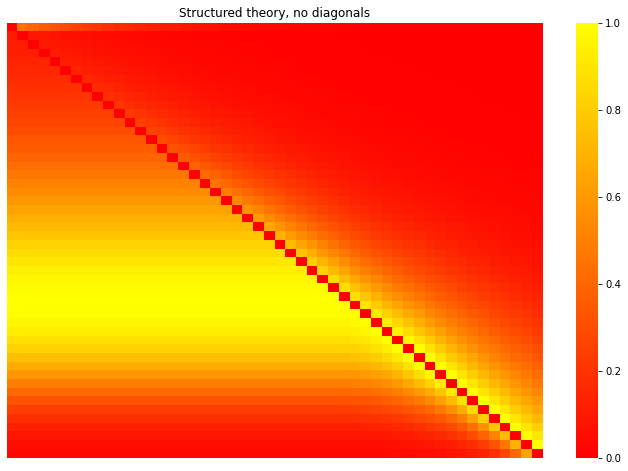

In [128]:
# heatmaps_seq(normalise(q_2_uppers,'colmax'),title="upper from structured theory!")
# heatmaps_seq(normalise(q_2_lowers,'colmax'),title="lower from structured theory!")
heatmaps_seq(normalise(q_2s,'colmax'),title="Structured theory, no diagonals")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


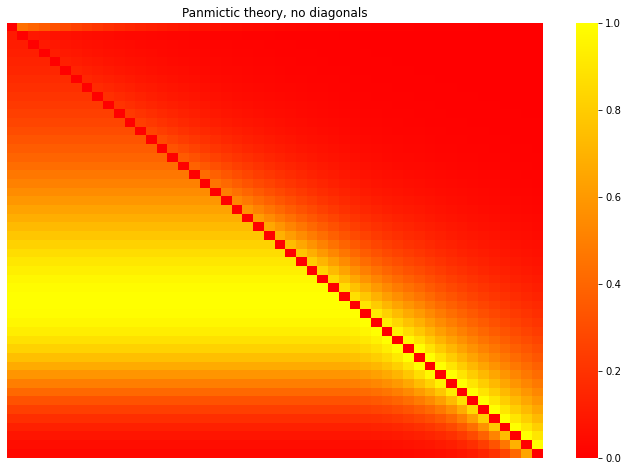

In [129]:
heatmaps_seq(normalise(q_2Ac,'colmax'),title="Panmictic theory, no diagonals")

Looks to me, just by eyeballing, that panmictic theory matches structed theory

In [131]:
checking_q_upper = q_2_upperAc - q_2_uppers
checking_q_lower = q_2_lowerAc - q_2_lowers
checking_q_all = q_Ac - q_s

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


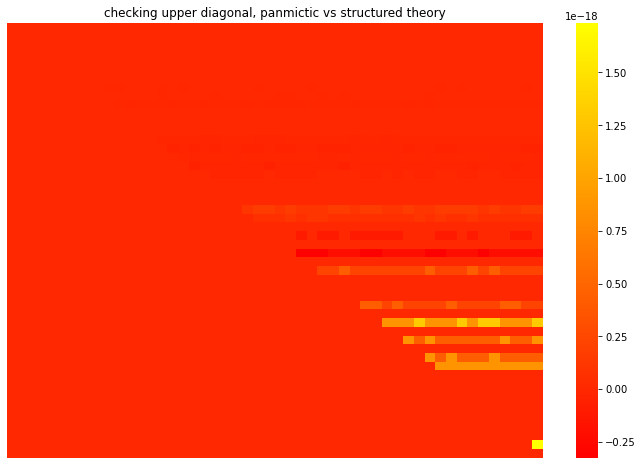

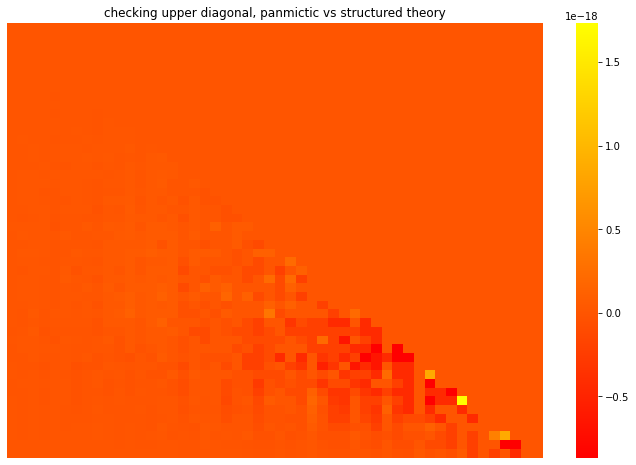

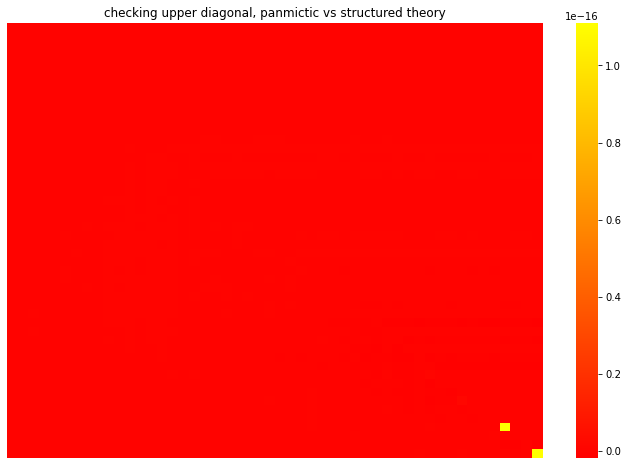

In [134]:
heatmaps_seq(-checking_q_upper,title="checking upper diagonal, panmictic vs structured theory") # minus to flip colours, looks weird otherwise
heatmaps_seq(checking_q_lower,title="checking upper diagonal, panmictic vs structured theory")
heatmaps_seq(checking_q_all,title="checking upper diagonal, panmictic vs structured theory")

Very small differences in TM. Not sure if that is ok?. I think it is

## Now try my theory for structured transition matrix and see if it fits observations

In [205]:
T_1 = T_np[25]*2*N_0
T_2 = T_np[35]*2*N_0
print('T_1 is {} and T_2 is {}'.format(T_1,T_2))
mig_prop = 0.3
seq_length=150e+06
N_0 = 10000

sim3 = split(N_0,mig_prop,T_1,T_2,seq_length)

T_1 is 9381.442505494031 and T_2 is 27096.22767576434
N is 10000
mig_prop is 0.3
t_1 is 9381.442505494031 and t_2 is 27096.22767576434
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 9381.442505494031 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 9381.442505494031
   - Mass migration: Lineages moved with probability 0.3 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 9381.442505494031 -- 27096.22767576434 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ gene

In [206]:
args

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


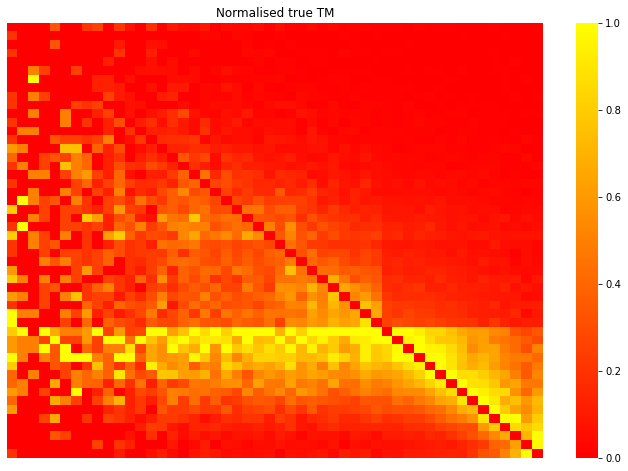

In [220]:
tmrca_data3 = get_coal_data(sim3, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim3.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3/(2e+04) # scale by 2N
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap


Now test with my theory

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


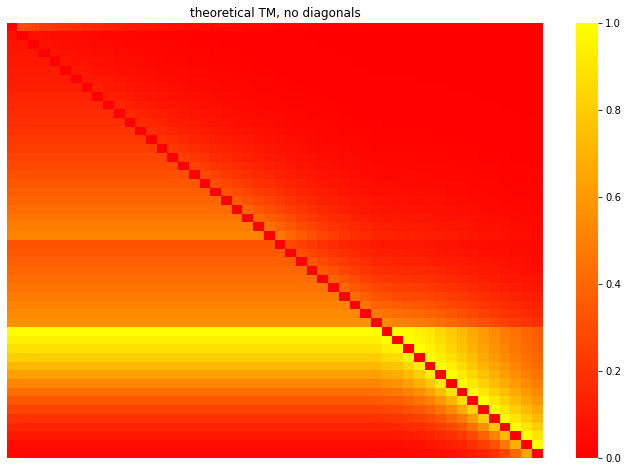

In [221]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[25:35] = 0.3
print(gamma_array)
q_2D, q_2_upperD, q_2_lowerD, q_1D, q_D = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2D,'colmax'),title='theoretical TM, no diagonals') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperD,'colmax'),title='theoretical TM, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerD,'colmax'),title='theoretical TM, lower ') # normalise this matrix and then plot heatmap


Now try and look at the actual differences.

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


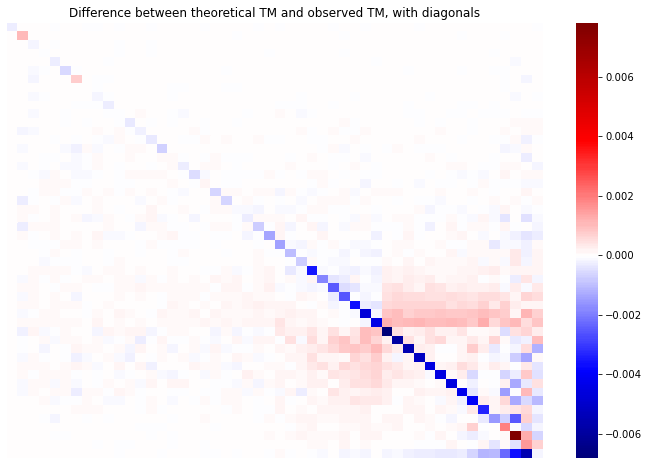

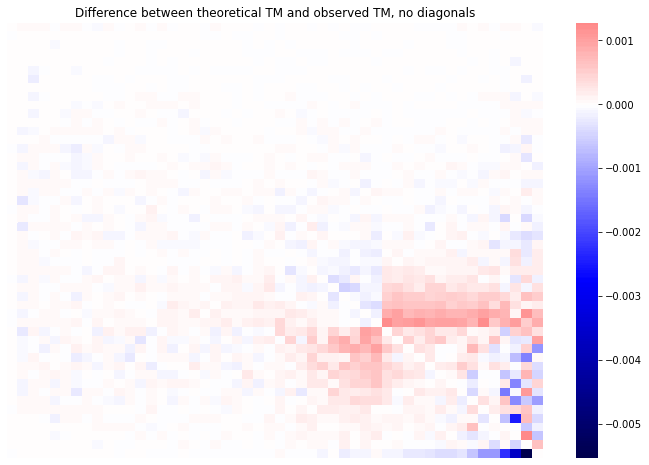

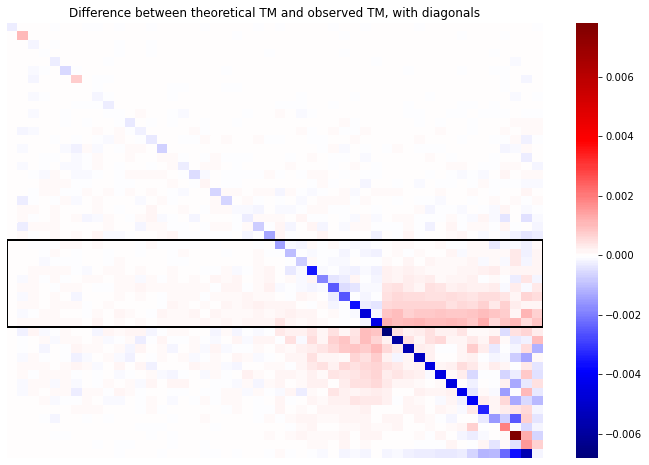

In [217]:
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_D_3 = q_D - tm_3 # difference between simulation 3's TM and theoretical TM for that history
diff_q_D_3_nd = np.copy(diff_q_D_3)
diff_q_D_3_nd = remove_diagonals(diff_q_D_3_nd)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_D_3,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_D_3_nd,title="Difference between theoretical TM and observed TM, no diagonals")


heatmaps_div_patch(diff_q_D_3,title="Difference between theoretical TM and observed TM, with diagonals",patch=[25,10])


In [203]:
# this heatmap works well for values between -1 and 1
def heatmaps_div_patch(matrix,title='',patch=[1,1]):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax.add_patch(Rectangle((0, patch[0]), len(matrix), patch[1], fill=False, edgecolor='black', lw=2))
#     ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

from matplotlib.patches import Rectangle

In [181]:
len(diff_q_D_3)

50